In [1]:
# Imports
import pandas as pd
import datetime as dt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE 

In [2]:
def clean_up_observations_and_add_rain_class(atg_obs_selected):
    no_erros_obs = atg_obs_selected.loc[(atg_obs_selected['Rain']!='M')&(atg_obs_selected['Temperature']!='M')&(atg_obs_selected['Pressure']!='M')&(atg_obs_selected['Relhum']!='M')&(atg_obs_selected['Relhum']!='0.00.')].copy()

    no_erros_obs['datetime_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_UTC']).tz_localize('UTC').tz_convert('US/Pacific')
    no_erros_obs['Date_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).date
    no_erros_obs['Time_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).time
    no_erros_obs['Rain'] = no_erros_obs['Rain'].astype(float)
    no_erros_obs['Temperature'] = no_erros_obs['Temperature'].astype(float)
    no_erros_obs['Pressure'] = no_erros_obs['Pressure'].astype(float)
    no_erros_obs['Relhum'] = no_erros_obs['Relhum'].astype(float)

    first_obs_each_period = no_erros_obs.resample(on='datetime_UTC', rule='30min')
    summed_rain_each_period = first_obs_each_period['Rain'].sum()

    lightrainfall_times = summed_rain_each_period[(summed_rain_each_period>0.0)]

    summed_rain_each_period.loc[lightrainfall_times.index] = 1

    # Extract Date, Time, Temperature, SumRain into data array
    atg_obs_necessary = pd.DataFrame()
    atg_obs_necessary['date'] = first_obs_each_period['Date_PST'].first()
    atg_obs_necessary['time'] = first_obs_each_period['Time_PST'].first()
    atg_obs_necessary['temperature'] = first_obs_each_period['Temperature'].first()
    atg_obs_necessary['pressure'] = first_obs_each_period['Pressure'].first()
    atg_obs_necessary['relhum'] = first_obs_each_period['Relhum'].first()
    atg_obs_necessary['rainfall_type'] = summed_rain_each_period

    atg_obs_necessary = atg_obs_necessary.dropna()
    data_arr = atg_obs_necessary.values

    return atg_obs_necessary, data_arr

In [3]:
atg_obs = pd.read_csv('../../Downloads/LFEM_data-.csv', low_memory=False, skiprows=1)
atg_obs.insert(0, 'datetime_UTC', pd.to_datetime(atg_obs['Date'] + atg_obs['Time'], format='%Y-%m-%d%H:%M'))

In [4]:
atg_obs_selected = atg_obs.copy() # Selecting dates
atg_obs_selected = atg_obs_selected.loc[(atg_obs['datetime_UTC']>=dt.datetime(2023,5,1))]

In [5]:
# Extract Date, Time, Temperature, SumRain into data array
atg_obs_necessary, data_arr = clean_up_observations_and_add_rain_class(atg_obs_selected)
atg_obs_necessary

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-05-01 17:00:00,2023-05-01,10:14:00,54.6,1007.6,61.8,0.0
2023-05-01 17:30:00,2023-05-01,10:30:00,53.9,1007.8,63.8,0.0
2023-05-01 18:00:00,2023-05-01,11:00:00,55.2,1007.5,62.4,0.0
2023-05-01 18:30:00,2023-05-01,11:30:00,54.1,1007.7,65.2,0.0
2023-05-01 19:00:00,2023-05-01,12:00:00,55.0,1007.4,63.7,0.0
...,...,...,...,...,...,...
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.0
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.0
2024-05-23 16:30:00,2024-05-23,09:30:00,53.2,1017.1,65.3,0.0


In [6]:
def select_times_around_specific_events(atg_obs_necessary, event, num_days_around):
    notable_event_times = atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']>=event].index

    relevant_events = pd.DataFrame()
    for event_time in notable_event_times:
        start_time = event_time-pd.Timedelta(days=num_days_around)
        end_time = event_time+pd.Timedelta(days=num_days_around)
        time_around_event = atg_obs_necessary.loc[start_time:end_time].copy()
        relevant_events = pd.concat([relevant_events, time_around_event]).drop_duplicates()
    
    return relevant_events

In [7]:
relevant_events = select_times_around_specific_events(atg_obs_necessary, 1, 30)
relevant_events

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-05-01 17:00:00,2023-05-01,10:14:00,54.6,1007.6,61.8,0.0
2023-05-01 17:30:00,2023-05-01,10:30:00,53.9,1007.8,63.8,0.0
2023-05-01 18:00:00,2023-05-01,11:00:00,55.2,1007.5,62.4,0.0
2023-05-01 18:30:00,2023-05-01,11:30:00,54.1,1007.7,65.2,0.0
2023-05-01 19:00:00,2023-05-01,12:00:00,55.0,1007.4,63.7,0.0
...,...,...,...,...,...,...
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.0
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.0
2024-05-23 16:30:00,2024-05-23,09:30:00,53.2,1017.1,65.3,0.0


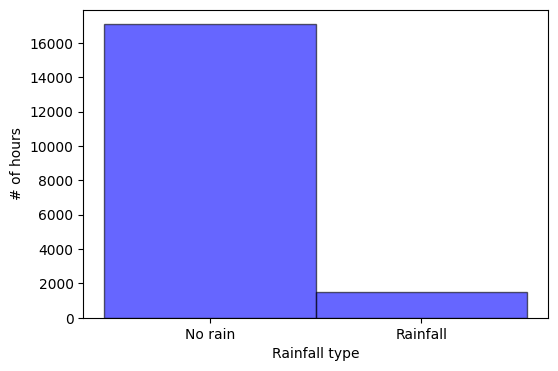

(array([17079,  1522]), array([0., 1., 2.]))

In [8]:
rain_counts, classes = np.histogram(relevant_events['rainfall_type'].values, bins=np.arange(0,relevant_events['rainfall_type'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,relevant_events['rainfall_type'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,relevant_events['rainfall_type'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [9]:
def get_processed_df_from_data(dataset):
    date_objs = pd.to_datetime(dataset['date'], format="%Y-%m-%d")
    time_objs = pd.to_datetime(dataset['time'], format='%H:%M:%S')

    months = pd.DatetimeIndex(date_objs).month
    hours = pd.DatetimeIndex(time_objs).hour

    processed_df = pd.DataFrame()
    processed_df['months_from_july'] = months
    # processed_df['time_of_day'] = ((hours-4)%24) / 6

    vals = dataset['temperature']
    processed_df['feature_1'] = vals.values

    vals = dataset['relhum']
    processed_df['feature_2'] = vals.values

    vals = dataset['pressure']
    processed_df['feature_3'] = vals.values

    processed_df['class'] = dataset['rainfall_type'].values
    return processed_df

In [10]:
def create_balanced_df(processed_df):
    ones_samps = processed_df[processed_df['class']==1].copy()
    num_ones = ones_samps.shape[0]

    dupl_processed_df = ones_samps
    group = 0
    under_group_samps = processed_df[processed_df['class']==group].copy()
    group_samps = under_group_samps.sample(n=(num_ones), replace=False, random_state=42)

    dupl_processed_df = pd.concat([dupl_processed_df, group_samps])

    return dupl_processed_df

In [11]:
raw_df_train_val, raw_under_df_test = train_test_split(relevant_events,random_state=42,test_size=0.2)
raw_under_df_train, raw_under_df_val = train_test_split(raw_df_train_val,random_state=42,test_size=0.25)

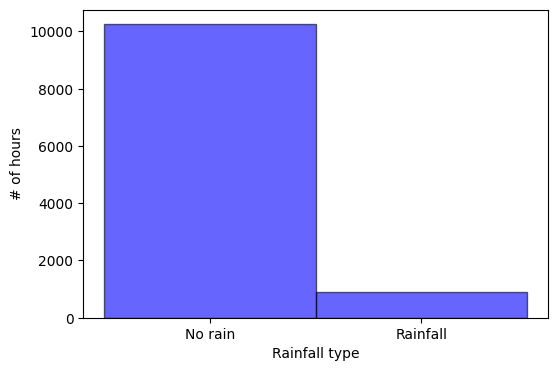

(array([10248,   912]), array([0., 1., 2.]))

In [12]:
under_sam_reltimes_tr = get_processed_df_from_data(raw_under_df_train)
rain_counts, classes = np.histogram(under_sam_reltimes_tr['class'].values, bins=np.arange(0,under_sam_reltimes_tr['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,under_sam_reltimes_tr['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,under_sam_reltimes_tr['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [13]:
processed_df_train = create_balanced_df(under_sam_reltimes_tr)
processed_df_train

,months_from_july,feature_1,feature_2,feature_3,class
0,12,45.6,93.0,1007.6,1.0
5,5,51.2,87.8,1009.2,1.0
9,5,51.9,94.3,1018.5,1.0
35,4,45.4,84.1,1019.1,1.0
50,4,52.7,57.0,1018.4,1.0
...,...,...,...,...,...
9927,1,44.3,94.7,995.7,0.0
2125,8,74.6,40.5,1006.8,0.0
5324,7,71.9,47.5,1016.2,0.0
9751,5,74.4,50.4,1014.2,0.0


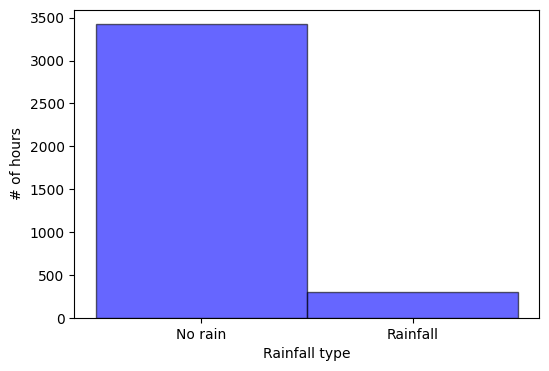

(array([3422,  298]), array([0., 1., 2.]))

In [14]:
processed_df_val = get_processed_df_from_data(raw_under_df_val)
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_val['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_val['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_val['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [15]:
# processed_df_val = create_balanced_df(under_sam_reltimes_va)
processed_df_val

,months_from_july,feature_1,feature_2,feature_3,class
0,3,50.4,67.6,1009.3,0.0
1,10,62.3,72.3,1012.5,0.0
2,11,43.0,91.0,1019.3,0.0
3,4,49.6,63.6,1018.9,0.0
4,12,42.1,68.3,1015.7,0.0
...,...,...,...,...,...
3715,3,42.3,83.8,1025.1,0.0
3716,5,55.8,81.0,1017.6,0.0
3717,6,67.9,53.1,1018.7,0.0
3718,2,48.4,78.6,1007.5,0.0


In [16]:
processed_df_train.shape, processed_df_val.shape

((1824, 5), (3720, 5))

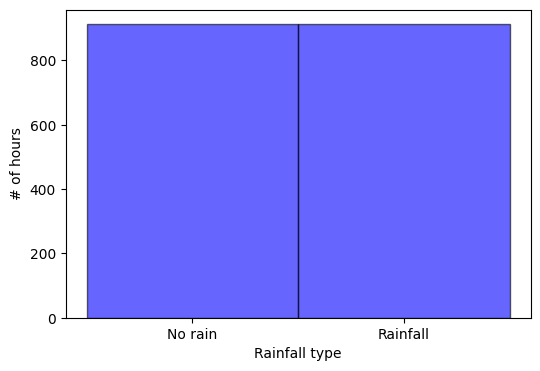

(array([912, 912]), array([0., 1., 2.]))

In [17]:
rain_counts, classes = np.histogram(processed_df_train['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

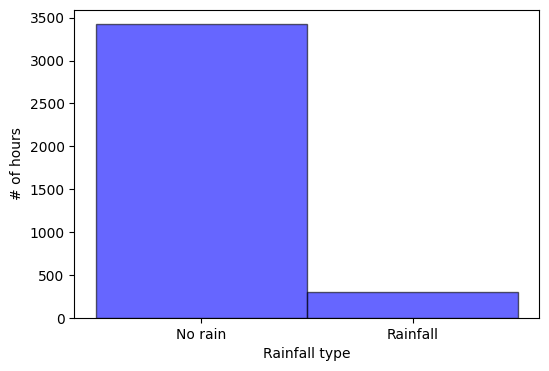

(array([3422,  298]), array([0., 1., 2.]))

In [18]:
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

In [19]:
processed_data_train = processed_df_train.values.astype(float)
processed_data_train.shape

(1824, 5)

In [20]:
processed_data_val = processed_df_val.values.astype(float)
processed_data_val.shape

(3720, 5)

In [21]:
x_data_train = processed_data_train[:, :processed_data_train.shape[1]-1]
y_train_labs = processed_data_train[:, processed_data_train.shape[1]-1:]
y_data_train = to_categorical(y_train_labs, int(y_train_labs.max()+1))
print(x_data_train[0], y_data_train[0])

[  12.    45.6   93.  1007.6] [0. 1.]


In [22]:
x_data_val = processed_data_val[:, :processed_data_val.shape[1]-1]
y_val_labs = processed_data_val[:, processed_data_val.shape[1]-1:]
y_data_val = to_categorical(y_val_labs, int(y_val_labs.max()+1))
print(x_data_val[0], y_data_val[0])

[   3.    50.4   67.6 1009.3] [1. 0.]


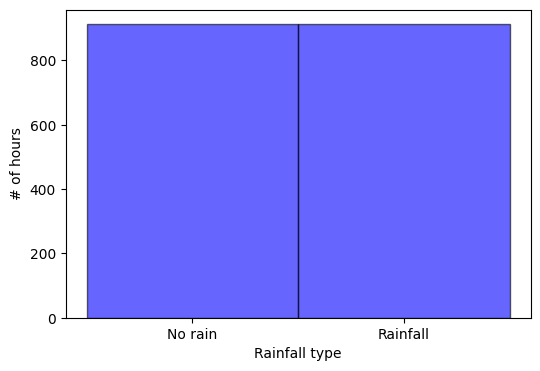

(array([912, 912]), array([0., 1., 2.]))

In [23]:
rain_counts, classes = np.histogram(y_train_labs, bins=np.arange(0,y_train_labs.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_train_labs.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_train_labs.max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

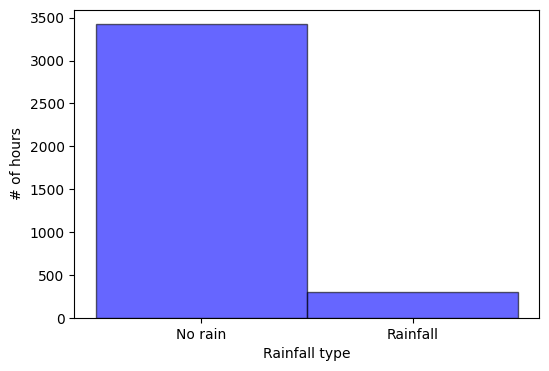

(array([3422,  298]), array([0., 1., 2.]))

In [24]:
rain_counts, classes = np.histogram(y_val_labs, bins=np.arange(0,y_val_labs.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_val_labs.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_val_labs.max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_data_train)
X_val_scaled = scaler.transform(x_data_val)

# Define the model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(x_data_train.shape[1],)))

# Hidden layers
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(int(y_train_labs.max()+1), activation='softmax'))  # Softmax for multiclass classification

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Print model summary
model.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                             

2024-06-02 12:03:55.441635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-02 12:03:55.441804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
X_train_scaled.shape, y_data_train.shape

((1824, 4), (1824, 2))

In [27]:
X_val_scaled.shape, y_data_val.shape

((3720, 4), (3720, 2))

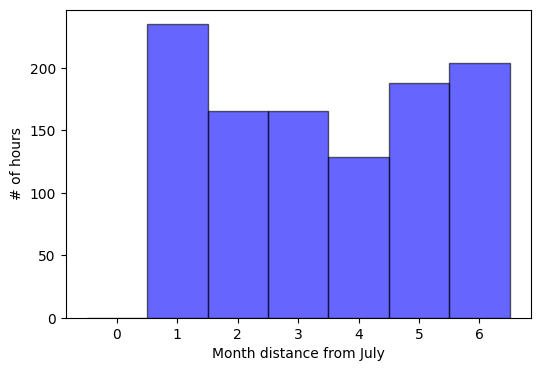

(array([  0, 235, 166, 166, 129, 188, 204]), array([0, 1, 2, 3, 4, 5, 6, 7]))

In [28]:
binwidth = 1
rain_counts, classes = np.histogram(x_data_train[:,0], bins=np.arange(0,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Month distance from July')
plt.show()
rain_counts, classes

In [29]:
X_train_scaled

array([[ 1.48766185, -0.69119148,  0.90223951, -0.30737521],
       [-0.34471964, -0.12340779,  0.59204133, -0.09546842],
       [-0.34471964, -0.05243483,  0.97978906,  1.13623977],
       ...,
       [ 0.17881793,  1.97536406, -1.81199458,  0.83162376],
       [-0.34471964,  2.22883892, -1.63899944,  0.56674028],
       [-0.34471964,  0.91076964, -1.5137271 ,  0.06346167]])

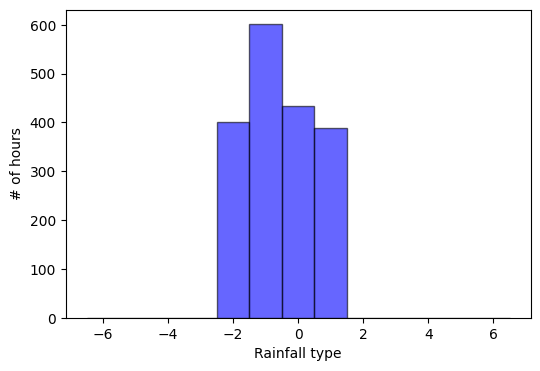

(array([  0,   0,   0,   0, 401, 601, 434, 388,   0,   0,   0,   0,   0]),
 array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7]))

In [30]:
binwidth = 1
rain_counts, classes = np.histogram(X_train_scaled[:,0], bins=np.arange(-6,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(-6,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [31]:
scaler.mean_, scaler.scale_

(array([   6.31688596,   52.41716009,   77.87532895, 1009.92083333]),
 array([ 3.82016521,  9.86291101, 16.76347667,  7.55048971]))

In [32]:
# Train the Model:
history = model.fit(
    X_train_scaled, y_data_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_data_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


2024-06-02 12:03:55.987947: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-06-02 12:03:56.272919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/57 [============================>.] - ETA: 0s - loss: 0.7648 - accuracy: 0.7941

2024-06-02 12:03:57.684015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - 3s 42ms/step - loss: 0.7616 - accuracy: 0.7966 - val_loss: 0.7048 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 2/100
57/57 [==============================] - 2s 35ms/step - loss: 0.6525 - accuracy: 0.8174 - val_loss: 0.6343 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 3/100
57/57 [==============================] - 2s 30ms/step - loss: 0.6057 - accuracy: 0.8202 - val_loss: 0.5668 - val_accuracy: 0.8027 - lr: 0.0010
Epoch 4/100
57/57 [==============================] - 2s 31ms/step - loss: 0.5708 - accuracy: 0.8268 - val_loss: 0.5360 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 5/100
57/57 [==============================] - 2s 30ms/step - loss: 0.5445 - accuracy: 0.8196 - val_loss: 0.5463 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 6/100
57/57 [==============================] - 2s 33ms/step - loss: 0.5269 - accuracy: 0.8251 - val_loss: 0.5236 - val_accuracy: 0.7866 - lr: 0.0010
Epoch 7/100
57/57 [==============================] - 2s 30ms/step - loss: 0.5109 -

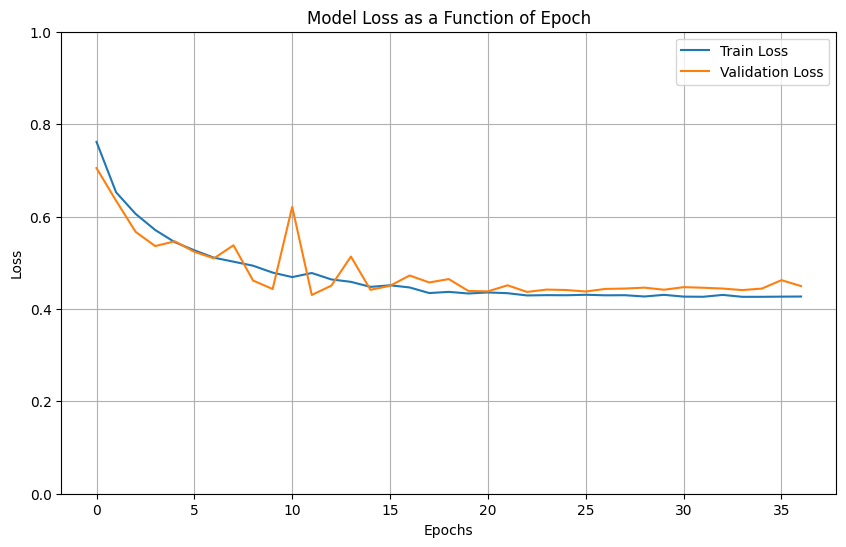

In [33]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Model Loss as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

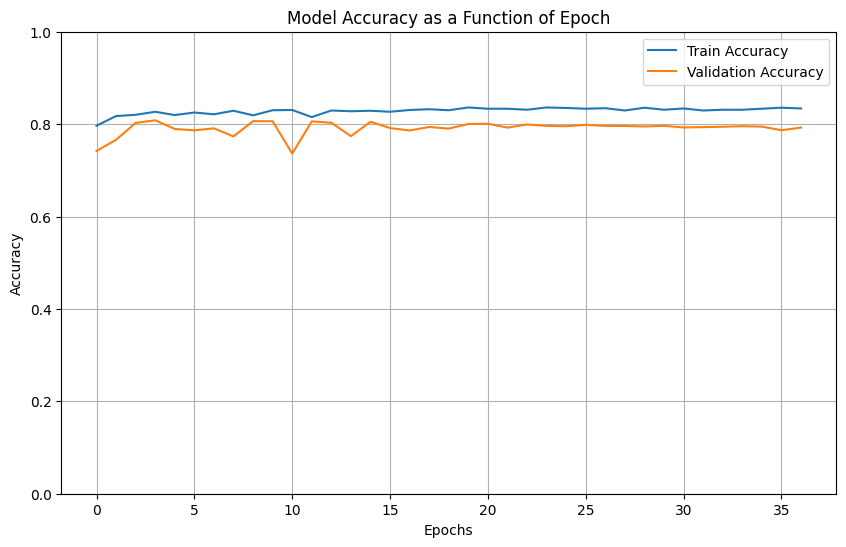

In [34]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Accuracy as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Evaluation (Is it worth, the loss is quite high suggesting that either the model architecture is quite poor (likely) or 
# that we need to better preprocess our data such as rain (also likely))

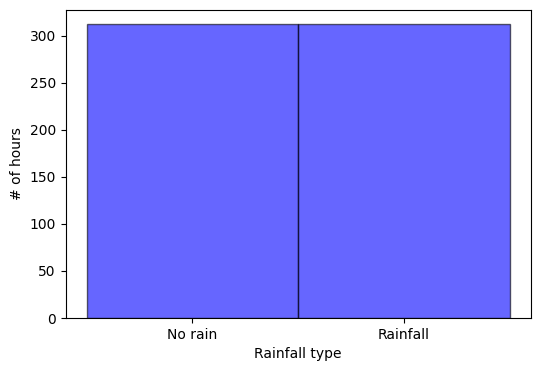

[312 312] [0. 1. 2.]
[  12.    50.1   94.1 1013.7] [0. 1.]


In [36]:
under_sam_reltimes_te = get_processed_df_from_data(raw_under_df_test)
processed_df_test = create_balanced_df(under_sam_reltimes_te)

rain_counts, classes = np.histogram(processed_df_test['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
print(rain_counts, classes)

processed_data_test = processed_df_test.values.astype(float)
x_data_test = processed_data_test[:, :processed_data_test.shape[1]-1]
y_test_labs = processed_data_test[:, processed_data_test.shape[1]-1:]
y_data_test = to_categorical(y_test_labs, int(y_test_labs.max()+1))
print(x_data_test[0], y_data_test[0])

In [37]:
scaler.mean_, scaler.scale_

(array([   6.31688596,   52.41716009,   77.87532895, 1009.92083333]),
 array([ 3.82016521,  9.86291101, 16.76347667,  7.55048971]))

In [38]:
X_test_scaled = scaler.transform(x_data_test)
predictions = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_data_test, verbose=2)

20/20 [==============================] - 0s 4ms/step


2024-06-02 12:05:03.324155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 - 0s - loss: 0.4680 - accuracy: 0.8173 - 210ms/epoch - 10ms/step


[0.46799758076667786, 0.817307710647583]

Confusion Matrix:
[[244  68]
 [ 46 266]]


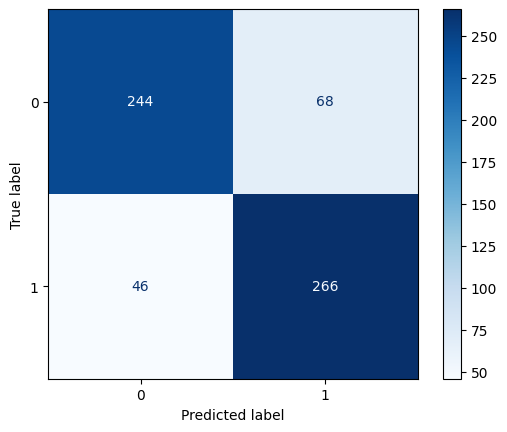

In [39]:
cm = confusion_matrix(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix:
[[244  68]
 [ 46 266]]


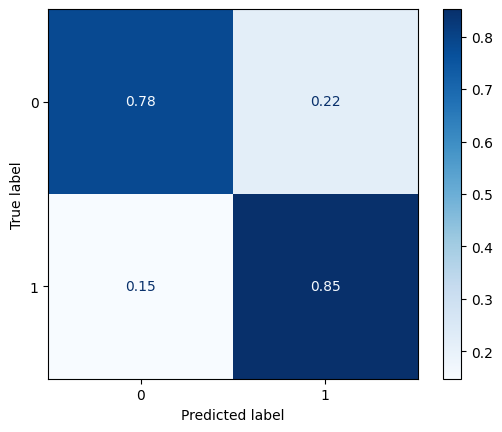

In [40]:
cm = confusion_matrix(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=(cm / np.sum(cm, axis=1).reshape(2, 1)), display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [41]:
f1_score(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1), average=None)

array([0.81063123, 0.82352941])

In [42]:
def create_oversampled_df_from_raw(processed_df):
    num_zeros = processed_df[processed_df['rainfall_type']==0].shape[0]

    zeros_samps = processed_df[processed_df['rainfall_type']==0].copy()
    dupl_processed_df = zeros_samps
    for group in np.arange(1, 3):
        under_group_samps = processed_df[processed_df['rainfall_type']==group].copy()
        if len(under_group_samps)>0:
            group_samps = under_group_samps.sample(n=(num_zeros-len(under_group_samps)), replace=True, random_state=42)
            
            np.random.seed(1)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['temperature'] = group_samps['temperature']+noise

            np.random.seed(2)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['pressure'] = group_samps['pressure']+noise

            np.random.seed(3)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['relhum'] = group_samps['relhum']+noise

            dupl_processed_df = pd.concat([dupl_processed_df, under_group_samps, group_samps])

    return dupl_processed_df

In [43]:
raw_under_df_test

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-09-20 17:30:00,2023-09-20,10:30:00,55.2,1014.3,82.0,0.0
2024-05-19 04:00:00,2024-05-18,21:00:00,51.9,1015.4,70.3,0.0
2023-06-07 20:30:00,2023-06-07,13:30:00,79.0,1006.3,26.3,0.0
2023-05-27 23:30:00,2023-05-27,16:30:00,68.2,1011.1,54.7,0.0
2024-04-14 03:30:00,2024-04-13,20:30:00,56.6,1009.2,62.0,0.0
...,...,...,...,...,...,...
2023-09-23 16:00:00,2023-09-23,09:00:00,59.5,1009.5,66.9,0.0
2024-05-13 07:00:00,2024-05-13,00:00:00,60.1,1011.4,61.9,0.0
2023-07-03 03:00:00,2023-07-02,20:00:00,76.3,1013.2,33.8,0.0


In [44]:
import calendar

 1/11 [=>............................] - ETA: 0s

11/11 [==============================] - 0s 8ms/step


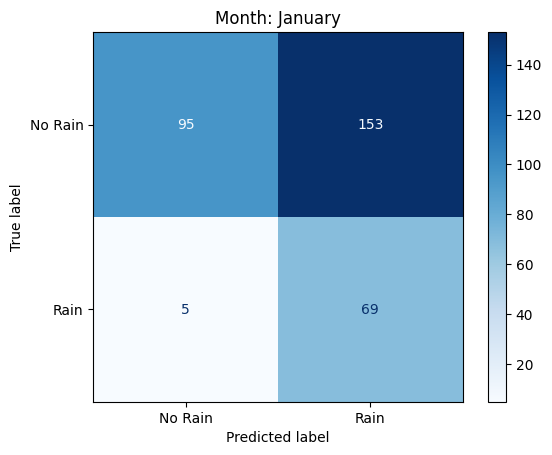

9/9 [==============================] - 0s 7ms/step


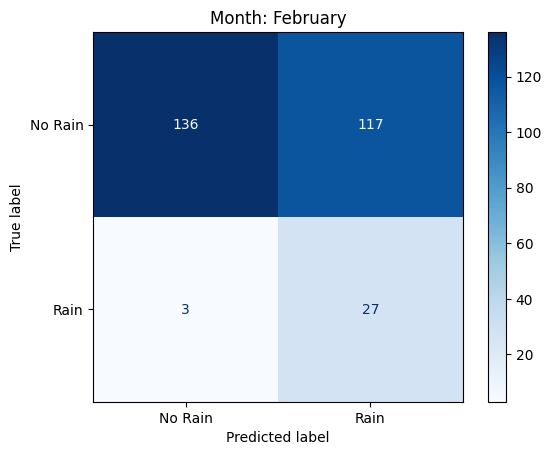

9/9 [==============================] - 0s 3ms/step


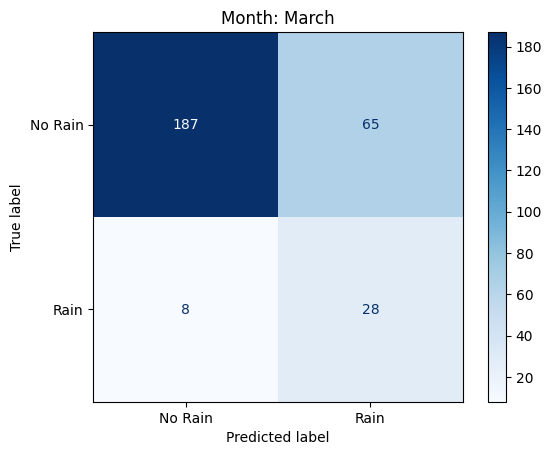

8/8 [==============================] - 0s 3ms/step


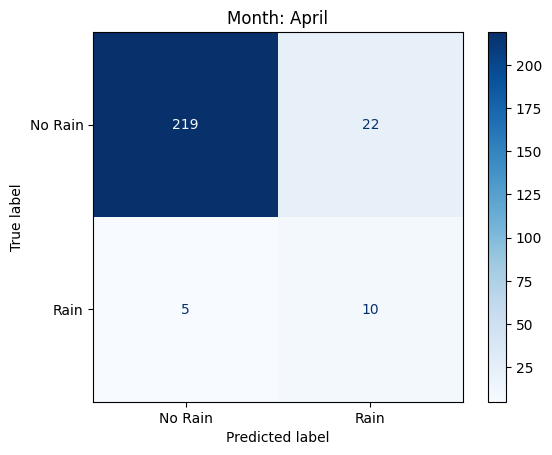

16/16 [==============================] - 0s 5ms/step


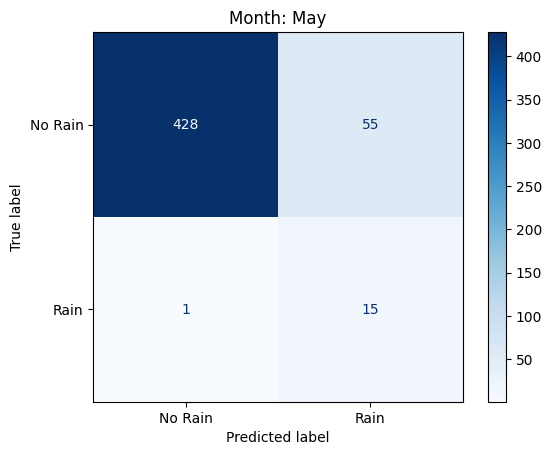

9/9 [==============================] - 0s 7ms/step


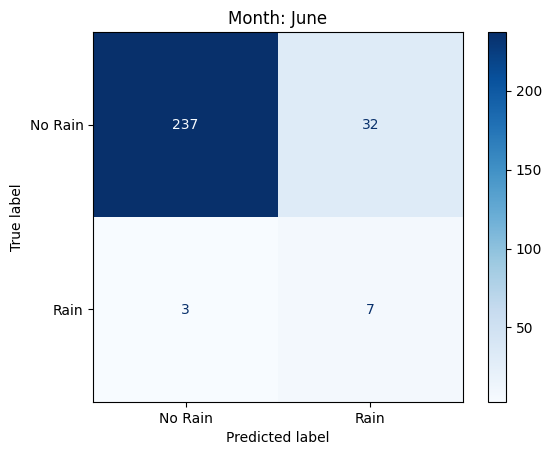

10/10 [==============================] - 0s 7ms/step


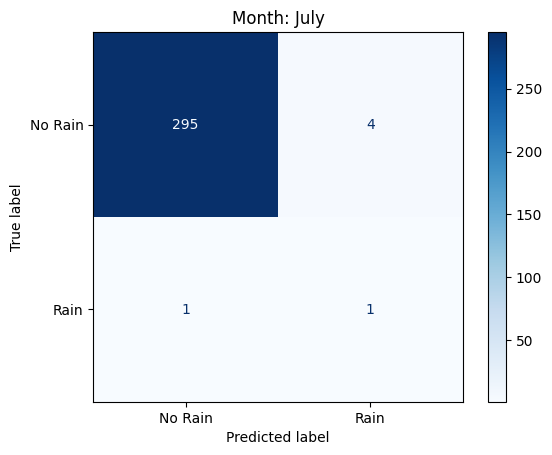

10/10 [==============================] - 0s 2ms/step


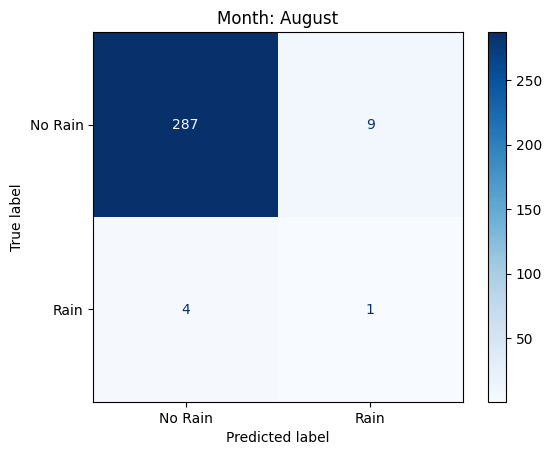

10/10 [==============================] - 0s 30ms/step


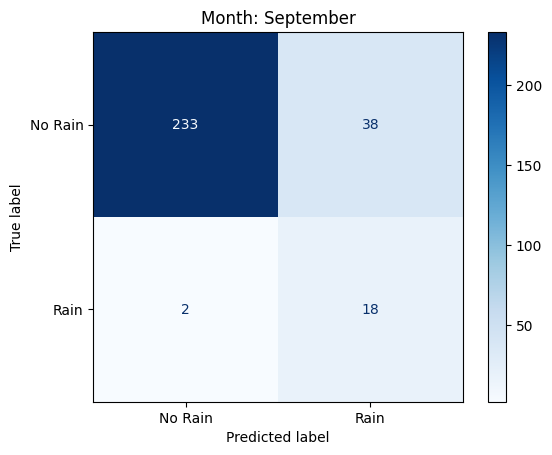

11/11 [==============================] - 0s 4ms/step


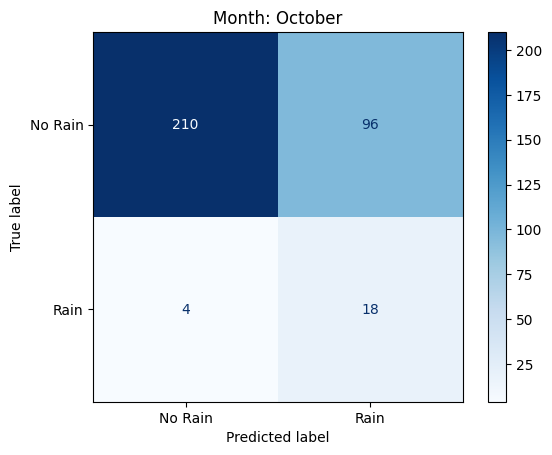

9/9 [==============================] - 0s 2ms/step


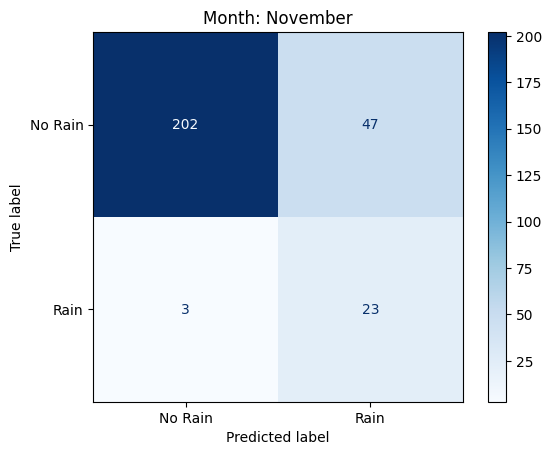

10/10 [==============================] - 0s 7ms/step


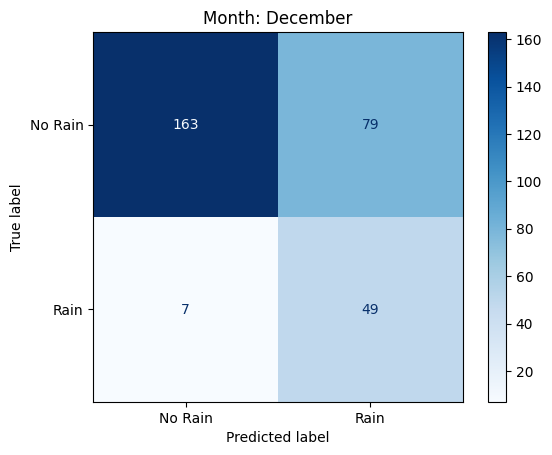

In [45]:
for month_num in np.arange(1, 13):
    test_data_sorted_month = raw_under_df_test.loc[(pd.DatetimeIndex(raw_under_df_test['date']).month==month_num), :].sort_index()
    # processed_test_sorted_month_balanced_raw = create_oversampled_df_from_raw(test_data_sorted_month).sort_index()
    processed_test_sorted_month = get_processed_df_from_data(test_data_sorted_month)
    processed_data_test_month = processed_test_sorted_month.values.astype(float)
    x_data_test_month = processed_data_test_month[:, :processed_data_test_month.shape[1]-1]
    y_test_labs_month = processed_data_test_month[:, processed_data_test_month.shape[1]-1:]
    y_data_test_month = to_categorical(y_test_labs_month, 3)

    X_test_scaled_month = scaler.transform(x_data_test_month)
    predictions_month = model.predict(X_test_scaled_month)

    cm = confusion_matrix(np.argmax(y_data_test_month, axis=1), np.argmax(predictions_month,axis=1))

    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Rain', 'Rain'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Month: {calendar.month_name[month_num]}')
    plt.show()